# Women in Data Science (WiDS) Datathon 2022 - Climate Change Evaluation

The goal of the competition this year is to analyze building energy efficiency and create models to predict building energy consumption, known as 'energy use intensity' (EUI).  The datasets contain building features, energy star ratings, building age, and the weather features where the building is located (anonymized). Energy use by buildings is a contibutor to climate change, and this datathon aims to understand building energy expenditures as a means to combat climate change. 


The datasets follow the Kaggle competition design.  They include training dataset and test dataset.  The training data has the target field but the test data does not.  The goal is to predict the target variable for the test dataset and submit it for scoring in Kaggle.  This dataset has a continuous target variable rather than binary variable.  The scoring by Kaggle is RMSE, which is used throughout my analysis for the project.

 


This jupyter notebook includes the steps required to pre-process the data.  These steps include the following:

1. Initial exploratory analysis of the datasets
2. Drop columns with too many missing values
3. Drop columns that are not needed
4. Evaluate features for outliers
    - remove outliers
5. One-Hot-Encoding for categorical data
6. Evaluating feature reduction and selection
    - Voting on features based on multiple RFE methods
    - Recursive Feature Elimination (RFE)
    
        - Lasso
        - Gradient Boosting
        - Random Forest
7. Loading data to PostgresSQL


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [2]:
train = pd.read_csv('wids_train.csv')
test = pd.read_csv('wids_test.csv')

# Description of training data

- 63 features
- 1 target column (site_eui) = continuous variable
- 4 categorical features
- 59 numerical features
    - 3 temperature values per month (3x12 = 36)
        - min, average, max values
    - count of days below or above certain temperatures
- 75757 records in training
- 9705 records in test


In [7]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194


In [8]:
test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097


# Evaluating distribution of target variable

Text(0.5, 1.0, 'Boxplot of target variable - Energy use by building')

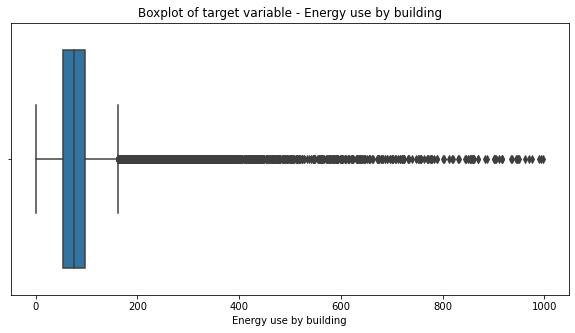

In [5]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train['site_eui'])
plt.xlabel('Energy use by building')
plt.title('Boxplot of target variable - Energy use by building')

Text(0.5, 1.0, 'Distribution of target variable - Energy use by building')

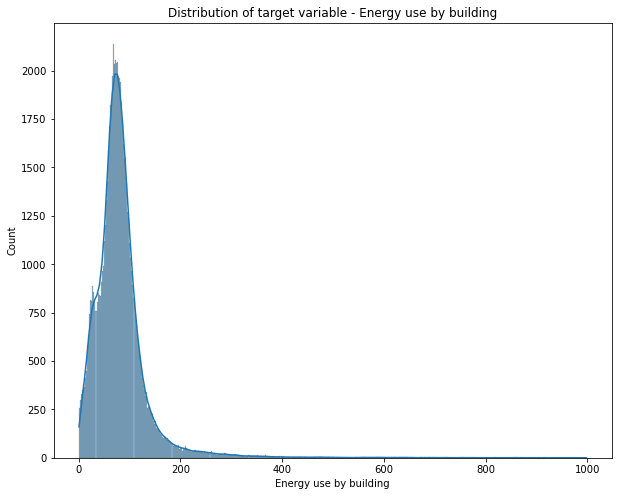

In [6]:
plt.figure(figsize=(10,8))
sns.histplot(data=train, x='site_eui',kde=True)

plt.xlabel('Energy use by building')
plt.title('Distribution of target variable - Energy use by building')

# Missing values in training data

In [6]:
missing_columns = [col for col in train.columns if train[col].isnull().any()]
missingvalues_count =train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count: Train')).loc[missingvalues_count.ne(0)]
missingValues_df.style.background_gradient(cmap="Pastel1")

,Null Values Count: Train
year_built,1837
energy_star_rating,26709
direction_max_wind_speed,41082
direction_peak_wind_speed,41811
max_wind_speed,41082
days_with_fog,45796


# Missing values in test data

In [7]:
missing_columns = [col for col in test.columns if test[col].isnull().any()]
missingvalues_count =test.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count: Test')).loc[missingvalues_count.ne(0)]
missingValues_df.style.background_gradient(cmap="Pastel1")

,Null Values Count: Test
year_built,92
energy_star_rating,2254
direction_max_wind_speed,8575
direction_peak_wind_speed,8575
max_wind_speed,8575
days_with_fog,9117


# Dropping variables from training and test data

Many of the variables with missing data have over 50% of the data missing.  These variables will be dropped from the training and test datasets and include: direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed, days_with_fog.  Additionally, the id field will be dropped because it is only an index for the records and doesn't provide additional data.  

Furthermore, the min, max and average temperatures for each month of the year are dropped because a median calculation was derived from the features of the dataset.  A total of 36 columns of data were related to the min, max, and average temperatures.  I decided to calculate the median of each month (min,max,avg) and calculate the difference from the median for each record.  Then, the three median difference calculations (for min,max,avg) were added together to create one value per month that was a representation of it's difference from the median.  It was possible to further join months together to simplify the variables further, but that will be a final step if only necessary to improve the error of the model.


In [3]:
train_drop = train.drop(['direction_max_wind_speed','direction_peak_wind_speed', 
                        'max_wind_speed', 'days_with_fog', 'id',
                        'january_min_temp','january_avg_temp','january_max_temp',
         'february_min_temp','february_avg_temp','february_max_temp',
         'march_min_temp','march_avg_temp','march_max_temp',
         'april_min_temp', 'april_avg_temp', 'april_max_temp',
         'may_min_temp','may_avg_temp','may_max_temp',
         'june_min_temp','june_avg_temp','june_max_temp',
         'july_min_temp','july_avg_temp','july_max_temp',
         'august_min_temp','august_avg_temp','august_max_temp',
         'september_min_temp','september_avg_temp','september_max_temp',
         'october_min_temp','october_avg_temp','october_max_temp',
         'november_min_temp','november_avg_temp','november_max_temp',
         'december_min_temp','december_avg_temp','december_max_temp'],axis=1)
test_drop = test.drop(['direction_max_wind_speed','direction_peak_wind_speed', 
                        'max_wind_speed', 'days_with_fog', 'id',
                        'january_min_temp','january_avg_temp','january_max_temp',
         'february_min_temp','february_avg_temp','february_max_temp',
         'march_min_temp','march_avg_temp','march_max_temp',
         'april_min_temp', 'april_avg_temp', 'april_max_temp',
         'may_min_temp','may_avg_temp','may_max_temp',
         'june_min_temp','june_avg_temp','june_max_temp',
         'july_min_temp','july_avg_temp','july_max_temp',
         'august_min_temp','august_avg_temp','august_max_temp',
         'september_min_temp','september_avg_temp','september_max_temp',
         'october_min_temp','october_avg_temp','october_max_temp',
         'november_min_temp','november_avg_temp','november_max_temp',
         'december_min_temp','december_avg_temp','december_max_temp'],axis=1)

# Impute missing values for training and test data
 
Both the training and test data have energy_star_rating and year_built variables with missing data.  These were imputed using mean and median, respectively.  KNN imputation was tried, but the results were the same as mean/median.

##### year built - imputing zeroes and NaNs

In [4]:
#year built, fill in with mean
#replace zero with mean
train_drop['year_built'] = train_drop['year_built'].replace(np.nan, 1952) #mean
train_drop['year_built'] = train_drop['year_built'].replace(0, 1952) #mean

test_drop['year_built'] = test_drop['year_built'].replace(np.nan, 1952) #mean
test_drop['year_built'] = test_drop['year_built'].replace(0, 1952) #mean

##### energy star rating - imputing zeroes and NaNs

In [5]:
train_drop['energy_star_rating'] = train_drop['energy_star_rating'].fillna(67) #median
train_drop['energy_star_rating'] = train_drop['energy_star_rating'].replace(0,67) #median

test_drop['energy_star_rating'] = test_drop['energy_star_rating'].fillna(67) #median
test_drop['energy_star_rating'] = test_drop['energy_star_rating'].replace(0,67) #median

# Evaluate outliers

Records in training data for year built include zero (which was imputed to a different value since it is incorrect).  There are also values below 1700.  This doesn't seem to be incorrect, but they are outliers for the dataset (in the long-tail). Due to the rarity of that data, these are considered outliers and will be removed.

In [6]:
# Remove build years less than 1700
# finding the index value for recrods with years below 1700
train_drop.sort_values('year_built', ascending=True)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
35472,4,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,83.0,42.7,1128,4875,...,-23.854710,-6.996667,2.113000,2.200000,-7.531839,-2.211871,0.000333,1.871032,-13.816600,0.000129
44951,5,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,81.0,42.7,1581,4460,...,-28.419226,-1.080000,7.629129,-3.066667,1.113323,9.239742,13.717000,-5.709613,8.666733,27.258194
15123,1,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,87.0,42.7,1331,4335,...,-1.193419,4.970000,2.596871,9.066667,9.564935,0.546194,-6.699667,-2.661226,7.766733,-2.209548
26876,3,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,79.0,25.6,1272,4670,...,-14.370839,0.653333,-2.096677,3.400000,4.161710,-4.131226,-2.866333,9.435548,-11.866600,-0.967613
56260,6,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,85.0,42.7,1489,4252,...,13.354968,-5.996667,0.903323,-2.000000,0.000419,8.449419,3.067000,5.000065,5.650067,-14.177290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57392,6,State_6,Residential,Multifamily_Uncategorized,250000.0,2015.0,72.0,42.7,1489,4252,...,13.354968,-5.996667,0.903323,-2.000000,0.000419,8.449419,3.067000,5.000065,5.650067,-14.177290
68417,6,State_8,Residential,Multifamily_Uncategorized,55000.0,2015.0,17.0,3.0,1114,5074,...,8.451742,-18.398966,-11.725710,-8.784483,-7.593667,-3.002194,-9.533000,-12.499935,-14.799933,-24.386968
13761,6,State_4,Commercial,Lodging_Dormitory_or_fraternity_sorority,184000.0,2015.0,22.0,219.8,986,5995,...,-20.016000,-16.863333,-16.032161,-3.678571,-19.427000,-11.324774,-4.299667,-5.822516,-10.271772,-64.725677
63997,6,State_6,Commercial,Warehouse_Selfstorage,96890.0,2015.0,67.0,25.0,1489,4252,...,13.354968,-5.996667,0.903323,-2.000000,0.000419,8.449419,3.067000,5.000065,5.650067,-14.177290


In [7]:
#removing indexes 
train_remove = train_drop.drop([35472,44951,15123,26876,56260,19948,56882,35896,24302,27251])
#train_remove.head(3)

In [8]:
#to csv
train_remove.to_csv('train_before_ohe.csv')

# Evaluate distribution after outlier removal and imputation

array([[<AxesSubplot:title={'center':'Year_Factor'}>,
        <AxesSubplot:title={'center':'floor_area'}>,
        <AxesSubplot:title={'center':'year_built'}>,
        <AxesSubplot:title={'center':'energy_star_rating'}>,
        <AxesSubplot:title={'center':'ELEVATION'}>,
        <AxesSubplot:title={'center':'cooling_degree_days'}>],
       [<AxesSubplot:title={'center':'heating_degree_days'}>,
        <AxesSubplot:title={'center':'precipitation_inches'}>,
        <AxesSubplot:title={'center':'snowfall_inches'}>,
        <AxesSubplot:title={'center':'snowdepth_inches'}>,
        <AxesSubplot:title={'center':'avg_temp'}>,
        <AxesSubplot:title={'center':'days_below_30F'}>],
       [<AxesSubplot:title={'center':'days_below_20F'}>,
        <AxesSubplot:title={'center':'days_below_10F'}>,
        <AxesSubplot:title={'center':'days_below_0F'}>,
        <AxesSubplot:title={'center':'days_above_80F'}>,
        <AxesSubplot:title={'center':'days_above_90F'}>,
        <AxesSubplot:title={'

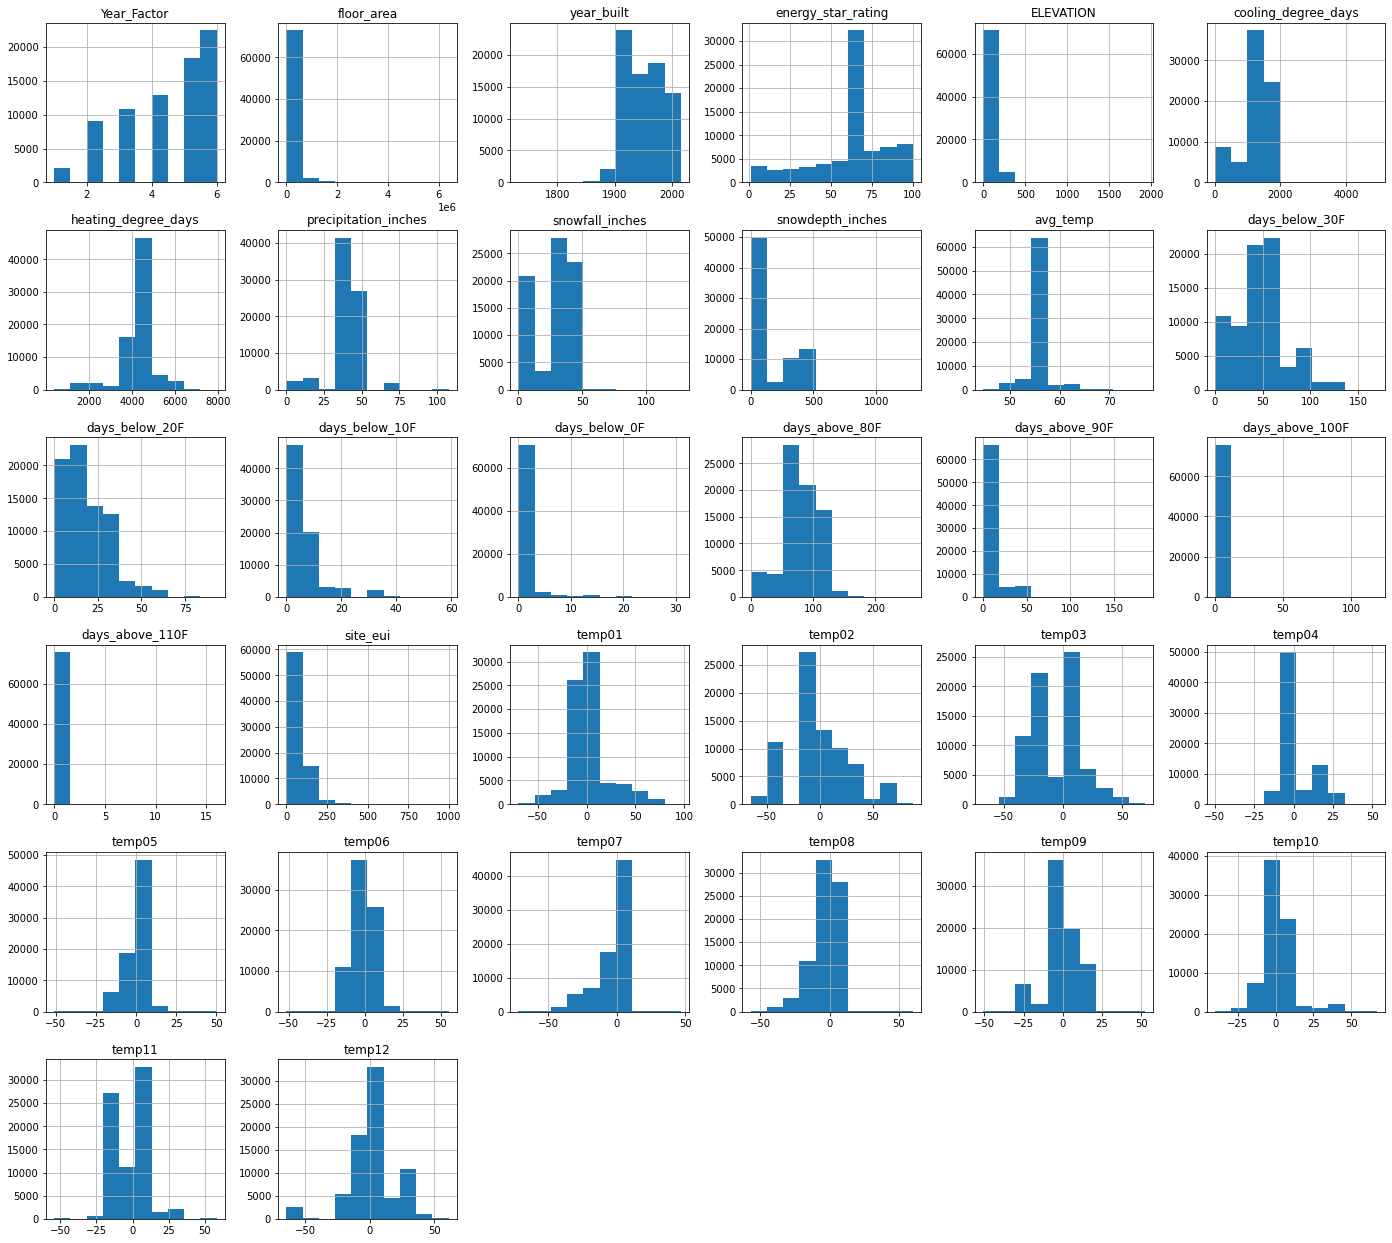

In [15]:
#view distributions of variables
plt.rcParams['figure.figsize'] = (24,22)
# histograms = train_remove.drop([''])
train_remove.hist()

# One Hot Encoding for categorical variables

In [9]:
train_ohe = pd.get_dummies(train_remove,columns=['State_Factor','building_class','facility_type'],drop_first=True)
test_ohe = pd.get_dummies(test_drop,columns=['State_Factor','building_class','facility_type'],drop_first=True)
train_ohe.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,...,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
#output the training and test data to csv for use in next notebook

train_ohe.to_csv('train_preprocessed.csv', index=False)
test_ohe.to_csv('test_preprocessed.csv',index=False)

In [30]:
#see all columns!!
pd.set_option('display.max_columns', None)
display(train_ohe)

Index(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       ...
       'facility_type_Retail_Uncategorized',
       'facility_type_Retail_Vehicle_dealership_showroom',
       'facility_type_Service_Drycleaning_or_Laundry',
       'facility_type_Service_Uncategorized',
       'facility_type_Service_Vehicle_service_repair_shop',
       'facility_type_Warehouse_Distribution_or_Shipping_center',
       'facility_type_Warehouse_Nonrefrigerated',
       'facility_type_Warehouse_Refrigerated',
       'facility_type_Warehouse_Selfstorage',
       'facility_type_Warehouse_Uncategorized'],
      dtype='object', length=126)

# Feature Selection and Reduction
_______________________________

### create model dataset & train-test-split (numeric columns, standardscaler)

In [66]:
train_numeric = train_remove.drop(columns=['State_Factor','building_class','facility_type'],axis=1)

#create data
X = train_numeric.drop(['site_eui'],axis=1)
y = train_numeric['site_eui']

#train-test-split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)
#scale data
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


### Lasso

In [54]:
def lasso(X_train,X_test,y_train,y_test,dataset):
    # Create and fit the LassoCV model on the training set
    print(f'LassoCV report for {dataset}:')
    lcv = LassoCV()
    lcv.fit(X_train, y_train)
    print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

    # Calculate R squared on the test set
    r_squared = lcv.score(X_test, y_test)
    print('The model explains {0:.1%} of the test set variance'.format(r_squared))

    # Create a mask for coefficients not equal to zero
    lcv_mask = lcv.coef_ != 0
    print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))
    
    lasso.var = lcv_mask

In [55]:
#call function
lasso(X_train,X_test,y_train,y_test,'numeric columns using standardscaler')

LassoCV report for numeric columns using standardscaler:
Optimal alpha = 0.022
The model explains 15.9% of the test set variance
25 features out of 31 selected


### Random Forest Regressor

In [72]:
def random_forest_regressor(X_train,X_test,y_train,y_test,features,dataset):
    print(f'RandomForestRegressor report for {dataset}:')
    rfe_rf = RFE(estimator=RandomForestRegressor(),
                    n_features_to_select=features, step=2, verbose=2) 
    rfe_rf.fit(X_train,y_train)

    y_pred_rfe = rfe_rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred_rfe))
    print(f'RMSE RFE with random forest regressor: {rmse}')
    rf_mask = rfe_rf.support_
    
    random_forest_regressor.var = rf_mask

In [57]:
#call function
random_forest_regressor(X_train,X_test,y_train,y_test,25,'numeric columns using standardscaler')

RandomForestRegressor report for numeric columns using standardscaler:
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
RMSE RFE with random forest regressor: 56.013407678625185


### Gradient Boost Regressor

In [73]:
def gradient_boost_regressor(X_train,X_test,y_train,y_test,features,dataset):
    print(f'GradientBoostRegressor report for {dataset}:')
    rfe_gb = RFE(estimator=GradientBoostingRegressor(),
                n_features_to_select=features, step=2, verbose=2)

    rfe_gb.fit(X_train,y_train)
    gb_mask = rfe_gb.support_
    
    y_pred_gb = rfe_gb.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred_gb))
    print(f'RMSE RFE with gradient boosting: {rmse}')
    gradient_boost_regressor.var = gb_mask

In [59]:
#call function
gradient_boost_regressor(X_train,X_test,y_train,y_test,25,'numeric columns using standardscaler')

GradientBoostRegressor report for numeric columns using standardscaler:
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
RMSE RFE with gradient boosting: 54.85513888109681


### Majority voting for feature reduction (lasso, random forest, and gradient boost)
The results of the three methods are combined and the features with the highest scores are selected.  This selection resulted in the following numeric features being ruled out:

- cooling degree days
- snowdepth inches
- days below 10
- days above 90
- days above 110
- temp08 (august)

In [74]:
def reduction_voting(rf_mask,gb_mask,lcv_mask,dataset):
    print(f'feature reduction voting report for {dataset}:')
    votes = np.sum([rf_mask,gb_mask,lcv_mask],axis=0) #could exclude lcv depending if it runs
    print(votes)
    #votes are how many of the models selected that feature (vote = keep in the model)
    rfe_mask = votes >=2 #number of votes to include 
    rfe_reduced_X = X.loc[:,rfe_mask]
    return rfe_reduced_X.columns   

In [65]:
#call function
reduction_voting(random_forest_regressor.var,gradient_boost_regressor.var,lasso.var,'numeric columns using standardscaler')

feature reduction voting report for numeric columns using standardscaler:
[3 3 3 3 3 0 3 3 3 3 2 3 3 1 2 2 1 2 0 3 3 3 2 3 3 3 1 3 3 2 3]


Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'heating_degree_days', 'precipitation_inches',
       'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F',
       'days_below_20F', 'days_below_0F', 'days_above_80F', 'days_above_100F',
       'temp01', 'temp02', 'temp03', 'temp04', 'temp05', 'temp06', 'temp07',
       'temp09', 'temp10', 'temp11', 'temp12'],
      dtype='object')

# Feature Selection with all columns (including one-hot encoding)

Features found not important are:
- facility_type_Public_Assembly_Stadium',
- facility_type_Public_Assembly_Uncategorized',
- State_Factor_State_2',
- temp12
- days_above_110F',

level 2
- facility_type_Food_Sales',
- 'facility_type_Lodging_Other',
- 'facility_type_Mixed_Use_Predominantly_Commercial',
- facility_type_Office_Medical_non_diagnostic',
- facility_type_Office_Mixed_use',
- facility_type_Public_Assembly_Movie_Theater',
- facility_type_Public_Assembly_Other',
- facility_type_Public_Assembly_Recreation',
- facility_type_Public_Assembly_Social_meeting',
- facility_type_Public_Safety_Penitentiary',
- facility_type_Religious_worship',
- facility_type_Retail_Enclosed_mall',
- facility_type_Retail_Uncategorized',
- facility_type_Retail_Vehicle_dealership_showroom',

In [69]:
#create model dataset
X = train_ohe.drop(['site_eui'],axis=1)
y = train_ohe['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=33)
#scale data
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

##### call the functions from above

In [70]:
lasso(X_train,X_test,y_train,y_test,'all columns with OHE using standardscaler')

LassoCV report for all columns with OHE using standardscaler:
Optimal alpha = 0.025
The model explains 34.4% of the test set variance
85 features out of 97 selected


In [75]:
random_forest_regressor(X_train,X_test,y_train,y_test,85,'all columns with OHE using standardscaler')

RandomForestRegressor report for all columns with OHE using standardscaler:
Fitting estimator with 97 features.
Fitting estimator with 95 features.
Fitting estimator with 93 features.
Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
RMSE RFE with random forest regressor: 42.277682686572895


In [76]:
gradient_boost_regressor(X_train,X_test,y_train,y_test,85,'all columns with OHE using standardscaler')

GradientBoostRegressor report for all columns with OHE using standardscaler:
Fitting estimator with 97 features.
Fitting estimator with 95 features.
Fitting estimator with 93 features.
Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
RMSE RFE with gradient boosting: 45.72517685431153


In [77]:
reduction_voting(random_forest_regressor.var,gradient_boost_regressor.var,lasso.var,'all columns with OHE using standardscaler')

feature reduction voting report for all columns with OHE using standardscaler:
[2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 1 2 2 3 3 2 2 2 2 3 3 2 2 1 1 3 2 3 3
 3 3 3 3 3 3 3 3 3 3 1 3 2 3 3 2 3 3 3 3 2 3 3 2 3 2 2 3 3 3 3 2 2 3 2 3 3
 2 2 3 3 2 2 2 3 3 2 3 3 3 3 2 2 3 3 3 3 3 3 3]


Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inches',
       'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'temp01', 'temp02', 'temp03', 'temp04', 'temp05', 'temp06', 'temp07',
       'temp08', 'temp09', 'temp10', 'temp11', 'temp12',
       'State_Factor_State_2', 'State_Factor_State_4', 'State_Factor_State_6',
       'State_Factor_State_8', 'building_class_Residential',
       'facility_type_5plus_Unit_Building', 'facility_type_Commercial_Other',
       'facility_type_Commercial_Unknown', 'facility_type_Data_Center',
       'facility_type_Education_College_or_university',
       'facility_type_Education_Other_classroom',
       'facility_type_Education_Preschool_or_daycare',
       'facility_type_Education_Uncategorized', 'facili

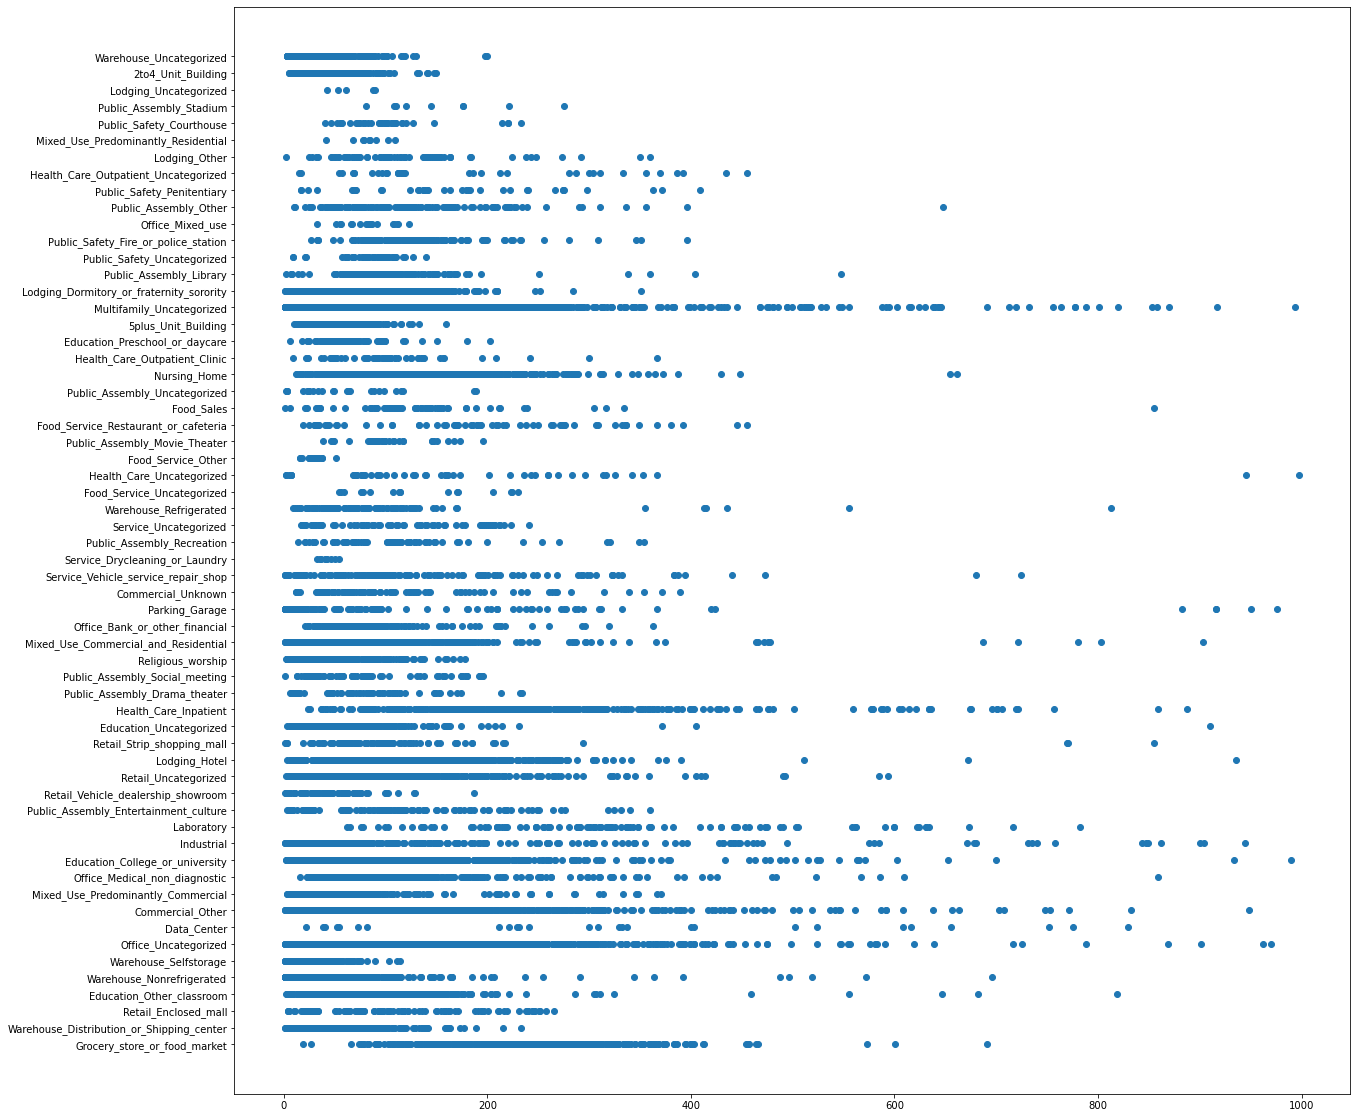

In [66]:
fig = plt.figure(figsize =(20, 20))
 
# Creating plot
plt.scatter(train_remove['site_eui'],train_remove['facility_type'])
 
# show plot
plt.show()

# df.T.boxplot(vert=False)
# plt.subplots_adjust(left=0.25)
# plt.show()

# Normalize instead of StandardScaler

In [79]:
X = train_ohe.drop(['site_eui'],axis=1)
X_norm = normalize(X,axis=0)
y = train_ohe['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X_norm,y,test_size=0.3,random_state=44)

#print(X_test_norm)

In [80]:
lasso(X_train,X_test,y_train,y_test,'all columns with OHE using normalize')

LassoCV report for all columns with OHE using normalize:
Optimal alpha = 0.000
The model explains 34.5% of the test set variance
86 features out of 97 selected


In [81]:
random_forest_regressor(X_train,X_test,y_train,y_test,86,'all columns with OHE using normalize')

RandomForestRegressor report for all columns with OHE using normalize:
Fitting estimator with 97 features.
Fitting estimator with 95 features.
Fitting estimator with 93 features.
Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
RMSE RFE with random forest regressor: 41.632391236946006


In [82]:
gradient_boost_regressor(X_train,X_test,y_train,y_test,86,'all columns with OHE using normalize')

GradientBoostRegressor report for all columns with OHE using normalize:
Fitting estimator with 97 features.
Fitting estimator with 95 features.
Fitting estimator with 93 features.
Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
RMSE RFE with gradient boosting: 46.319910068999796


In [83]:
reduction_voting(random_forest_regressor.var,gradient_boost_regressor.var,lasso.var,'all columns with OHE using normalize')

feature reduction voting report for all columns with OHE using normalize:
[3 3 2 3 3 3 2 3 3 3 2 2 3 3 3 3 3 3 1 2 2 3 3 3 2 2 3 3 3 3 2 2 3 3 1 3 3
 3 3 3 3 3 3 3 3 3 2 1 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 1 3 3 3 3 2 2 3 2 2 2
 3 3 3 3 2 2 2 3 3 1 3 2 3 3 3 2 3 3 3 3 3 3 3]


Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inches',
       'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'temp01', 'temp02', 'temp03', 'temp04', 'temp05', 'temp06', 'temp07',
       'temp08', 'temp09', 'temp10', 'temp11', 'temp12',
       'State_Factor_State_10', 'State_Factor_State_11',
       'State_Factor_State_2', 'State_Factor_State_6', 'State_Factor_State_8',
       'building_class_Residential', 'facility_type_5plus_Unit_Building',
       'facility_type_Commercial_Other', 'facility_type_Commercial_Unknown',
       'facility_type_Data_Center',
       'facility_type_Education_College_or_university',
       'facility_type_Education_Other_classroom',
       'facility_type_Education_Preschool_or_daycare',
       'facility_type_

In [89]:
#normalized features to keep

train_preprocessed = train_ohe[['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inches',
       'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'temp01', 'temp02', 'temp03', 'temp04', 'temp05', 'temp06', 'temp07',
       'temp08', 'temp09', 'temp10', 'temp11', 'temp12',
       'State_Factor_State_10', 'State_Factor_State_11',
       'State_Factor_State_2', 'State_Factor_State_8',
       'building_class_Residential', 'facility_type_5plus_Unit_Building',
       'facility_type_Commercial_Other', 'facility_type_Commercial_Unknown',
       'facility_type_Data_Center',
       'facility_type_Education_College_or_university',
       'facility_type_Education_Other_classroom',
       'facility_type_Education_Preschool_or_daycare',
       'facility_type_Education_Uncategorized', 'facility_type_Food_Sales',
       'facility_type_Food_Service_Restaurant_or_cafeteria',
       'facility_type_Food_Service_Uncategorized',
       'facility_type_Grocery_store_or_food_market',
       'facility_type_Health_Care_Inpatient',
       'facility_type_Health_Care_Outpatient_Clinic',
       'facility_type_Health_Care_Outpatient_Uncategorized',
       'facility_type_Health_Care_Uncategorized', 'facility_type_Industrial',
       'facility_type_Laboratory',
       'facility_type_Lodging_Dormitory_or_fraternity_sorority',
       'facility_type_Lodging_Hotel', 'facility_type_Lodging_Other',
       'facility_type_Mixed_Use_Commercial_and_Residential',
       'facility_type_Mixed_Use_Predominantly_Commercial',
       'facility_type_Multifamily_Uncategorized', 'facility_type_Nursing_Home',
       'facility_type_Office_Bank_or_other_financial',
       'facility_type_Office_Medical_non_diagnostic',
       'facility_type_Office_Mixed_use', 'facility_type_Office_Uncategorized',
       'facility_type_Parking_Garage',
       'facility_type_Public_Assembly_Drama_theater',
       'facility_type_Public_Assembly_Entertainment_culture',
       'facility_type_Public_Assembly_Library',
       'facility_type_Public_Assembly_Movie_Theater',
       'facility_type_Public_Assembly_Other',
       'facility_type_Public_Assembly_Recreation',
       'facility_type_Public_Assembly_Social_meeting',
       'facility_type_Public_Assembly_Stadium',
       'facility_type_Public_Assembly_Uncategorized',
       'facility_type_Public_Safety_Courthouse',
       'facility_type_Public_Safety_Fire_or_police_station',
       'facility_type_Public_Safety_Penitentiary',
       'facility_type_Religious_worship', 'facility_type_Retail_Enclosed_mall',
       'facility_type_Retail_Strip_shopping_mall',
       'facility_type_Retail_Uncategorized',
       'facility_type_Retail_Vehicle_dealership_showroom',
       'facility_type_Service_Drycleaning_or_Laundry',
       'facility_type_Service_Uncategorized',
       'facility_type_Service_Vehicle_service_repair_shop',
       'facility_type_Warehouse_Distribution_or_Shipping_center',
       'facility_type_Warehouse_Nonrefrigerated',
       'facility_type_Warehouse_Refrigerated',
       'facility_type_Warehouse_Selfstorage',
       'facility_type_Warehouse_Uncategorized','site_eui']]
train_preprocessed.head()



,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,...,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized,site_eui
0,1,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,248.682615
1,1,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,1,0,0,0,0,26.500150
2,1,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,24.693619
3,1,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,48.406926
4,1,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,...,0,0,0,0,0,1,0,0,0,3.899395


In [91]:
#features to keep based on feature reduction

#normalized features to keep

test_preprocessed = test_ohe[['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inches',
       'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'temp01', 'temp02', 'temp03', 'temp04', 'temp05', 'temp06', 'temp07',
       'temp08', 'temp09', 'temp10', 'temp11', 'temp12',
       'State_Factor_State_10', 'State_Factor_State_11',
       'State_Factor_State_2', 'State_Factor_State_8',
       'building_class_Residential', 'facility_type_5plus_Unit_Building',
       'facility_type_Commercial_Other', 'facility_type_Commercial_Unknown',
       'facility_type_Data_Center',
       'facility_type_Education_College_or_university',
       'facility_type_Education_Other_classroom',
       'facility_type_Education_Preschool_or_daycare',
       'facility_type_Education_Uncategorized', 'facility_type_Food_Sales',
       'facility_type_Food_Service_Restaurant_or_cafeteria',
       'facility_type_Food_Service_Uncategorized',
       'facility_type_Grocery_store_or_food_market',
       'facility_type_Health_Care_Inpatient',
       'facility_type_Health_Care_Outpatient_Clinic',
       'facility_type_Health_Care_Outpatient_Uncategorized',
       'facility_type_Health_Care_Uncategorized', 'facility_type_Industrial',
       'facility_type_Laboratory',
       'facility_type_Lodging_Dormitory_or_fraternity_sorority',
       'facility_type_Lodging_Hotel', 'facility_type_Lodging_Other',
       'facility_type_Mixed_Use_Commercial_and_Residential',
       'facility_type_Mixed_Use_Predominantly_Commercial',
       'facility_type_Multifamily_Uncategorized', 'facility_type_Nursing_Home',
       'facility_type_Office_Bank_or_other_financial',
       'facility_type_Office_Medical_non_diagnostic',
       'facility_type_Office_Mixed_use', 'facility_type_Office_Uncategorized',
       'facility_type_Parking_Garage',
       'facility_type_Public_Assembly_Drama_theater',
       'facility_type_Public_Assembly_Entertainment_culture',
       'facility_type_Public_Assembly_Library',
       'facility_type_Public_Assembly_Movie_Theater',
       'facility_type_Public_Assembly_Other',
       'facility_type_Public_Assembly_Recreation',
       'facility_type_Public_Assembly_Social_meeting',
       'facility_type_Public_Assembly_Stadium',
       'facility_type_Public_Assembly_Uncategorized',
       'facility_type_Public_Safety_Courthouse',
       'facility_type_Public_Safety_Fire_or_police_station',
       'facility_type_Public_Safety_Penitentiary',
       'facility_type_Religious_worship', 'facility_type_Retail_Enclosed_mall',
       'facility_type_Retail_Strip_shopping_mall',
       'facility_type_Retail_Uncategorized',
       'facility_type_Retail_Vehicle_dealership_showroom',
       'facility_type_Service_Drycleaning_or_Laundry',
       'facility_type_Service_Uncategorized',
       'facility_type_Service_Vehicle_service_repair_shop',
       'facility_type_Warehouse_Distribution_or_Shipping_center',
       'facility_type_Warehouse_Nonrefrigerated',
       'facility_type_Warehouse_Refrigerated',
       'facility_type_Warehouse_Selfstorage',
       'facility_type_Warehouse_Uncategorized']]
test_preprocessed.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,...,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,7,28484.0,1994.0,37.0,2.4,342,2112,25.24,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,21906.0,1961.0,55.0,45.7,342,2112,25.24,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,16138.0,1950.0,1.0,59.1,342,2112,25.24,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,97422.0,1971.0,34.0,35.4,342,2112,25.24,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,61242.0,1942.0,35.0,1.8,342,2112,25.24,0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Output preprocessed datasets

In [92]:
#output the training and test data to csv for use in next notebook
train_preprocessed.to_csv('train_preprocessed.csv', index=False)
test_preprocessed.to_csv('test_preprocessed.csv',index=False)